# Yelp Restaurants Reviews Classification and Topics Recognition

## Import all necessary modules and set paths

In [21]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
import json

import os
from collections import Counter
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

# Text Analytics
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Cross Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE # Upsampling

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


# import the garbage collection
import gc

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Set maximum number of rows,columns to be shown. Maximum column width made to 500.
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.notebook_repr_html', True)

In [4]:
os.chdir("C:\Master\PD_Career\Courses\Springboard\Capstone Project 2")

#data directory
data_path = "yelp-datasets/"
intermediate_data_path = "yelp-datasets/intermediate/"
source_data_path = "yelp-datasets/source/"
submit_data_path = "yelp-datasets/submit/"

## Data Preview
First, We will preview the datasets by exploring how the data is stored in the source files. <br>.

In [3]:
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    print(business_json_file.readline())

{"business_id":"1SWheh84yJXfytovILXOAQ","name":"Arizona Biltmore Golf Club","address":"2818 E Camino Acequia Drive","city":"Phoenix","state":"AZ","postal_code":"85016","latitude":33.5221425,"longitude":-112.0184807,"stars":3.0,"review_count":5,"is_open":0,"attributes":{"GoodForKids":"False"},"categories":"Golf, Active Life","hours":null}



In [4]:
with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
    print(review_json_file.readline())

{"review_id":"Q1sbwvVQXV2734tPgoKj4Q","user_id":"hG7b0MtEbXx5QzbzE6C_VA","business_id":"ujmEBvifdJM6h6RLv4wQIg","stars":1.0,"useful":6,"funny":1,"cool":0,"text":"Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.","date":"2013-05-07 04:34:36"}



From the below two previews, it is evident that each row of the dataset is stored in json format. <br>
Let's look at a few business categories to check the types of establishments in yelp dataset. <br>
We will also be devising few categories for restaurants we would like to study further in the project. <br> 

In [5]:
# Preview few categories for the business json
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 1000:
            break
        else:
            business_record = json.loads(business_json)
            print(business_record[u'categories'])

Golf, Active Life
Specialty Food, Restaurants, Dim Sum, Imported Food, Food, Chinese, Ethnic Food, Seafood
Sushi Bars, Restaurants, Japanese
Insurance, Financial Services
Plumbing, Shopping, Local Services, Home Services, Kitchen & Bath, Home & Garden, Water Heater Installation/Repair
Shipping Centers, Couriers & Delivery Services, Local Services, Printing Services
Beauty & Spas, Hair Salons
Hair Salons, Hair Stylists, Barbers, Men's Hair Salons, Cosmetics & Beauty Supply, Shopping, Beauty & Spas
Nail Salons, Beauty & Spas, Day Spas
Beauty & Spas, Nail Salons, Day Spas, Massage
Local Services, Professional Services, Computers, Shopping, Home Services, IT Services & Computer Repair, Internet Service Providers, Web Design
Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food
Bars, Nightlife, Pubs, Barbers, Beauty & Spas, Irish Pub
Italian, Restaurants, Pizza, Chicken Wings
Bakeries, Food
Fitness & Instruction, Active Life, Yoga
Hair Stylists, Beauty & Spas, Hair Salons, Men

Waxing, Eyelash Service, Beauty & Spas, Hair Removal, Skin Care
Cocktail Bars, Italian, American (New), Nightlife, Bars, Pizza, Restaurants
Day Spas, Hair Salons, Beauty & Spas
Delis, Restaurants, Sandwiches, Pizza
Restaurants, Italian, Pizza
Post Offices, Notaries, Shipping Centers, Local Services, Mailbox Centers, Printing Services, Public Services & Government
Foundation Repair, Contractors, Waterproofing, Home Services
Education, Middle Schools & High Schools
Vietnamese, Restaurants
Food, Breakfast & Brunch, Ice Cream & Frozen Yogurt, Mexican, Cafes, Restaurants
Walking Tours, Tours, Hotels & Travel
Home Services, Professional Services, Real Estate, Real Estate Agents, Real Estate Services
Fruits & Veggies, Delis, Restaurants, Bakeries, Specialty Food, Farms, Arts & Entertainment, Food
Home Services, Mortgage Brokers, Real Estate
Hair Salons, Nail Salons, Beauty & Spas, Makeup Artists, Day Spas, Eyelash Service
Auto Repair, Car Dealers, Auto Detailing, Body Shops, Automotive
Tree S

As there are many categories, lets visualize it using a Word Cloud.

In [45]:
# Print a Word Cloud on Categories
business_all_categories=[]
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 10000:
            break
        else:
            business_record = json.loads(business_json)
            if business_record[u'categories'] is not None:
                business_all_categories.append(business_record[u'categories'])
                categories = [x.strip().lower() for x in business_record[u'categories'].split(',')]
                business_categories+= categories
                
print(business_categories[:5])
print(business_all_categories[:5])

['golf', 'active life', 'specialty food', 'restaurants', 'dim sum']
['Golf, Active Life', 'Specialty Food, Restaurants, Dim Sum, Imported Food, Food, Chinese, Ethnic Food, Seafood', 'Sushi Bars, Restaurants, Japanese', 'Insurance, Financial Services', 'Plumbing, Shopping, Local Services, Home Services, Kitchen & Bath, Home & Garden, Water Heater Installation/Repair']


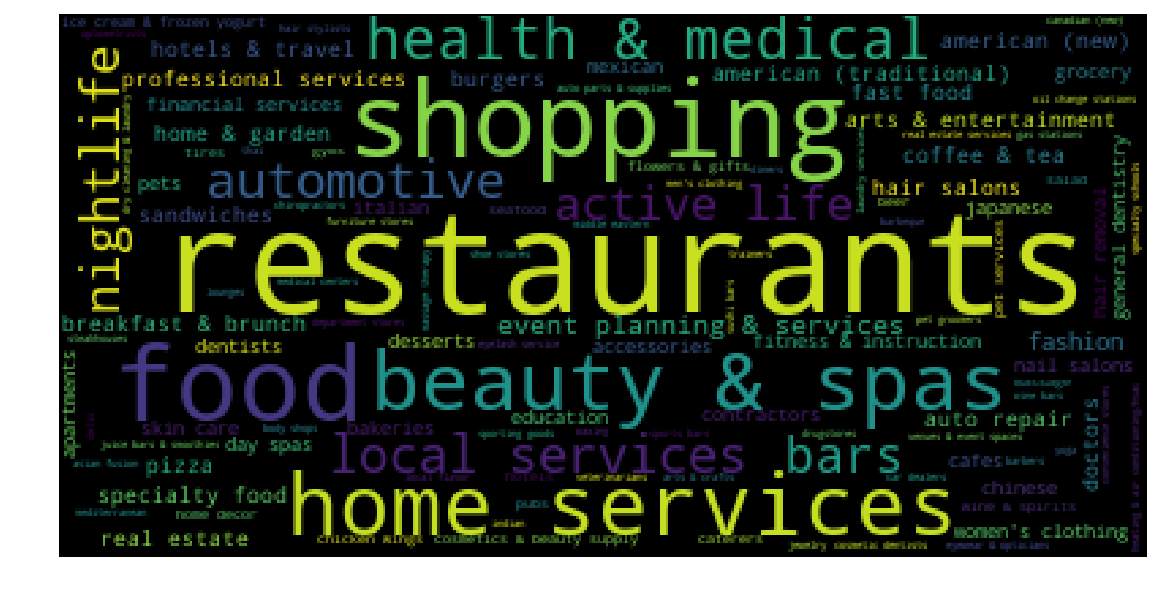

In [39]:
frequency_dist = nltk.FreqDist(business_categories)
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [51]:
# We will now try to visualize the categoreis that do not contain restaurants but contain food
# to be certain if there are other categories we should choose.

other_restaurants = [x for x in business_all_categories if 'food' in x.lower() and 'restaurants' not in x.lower()]

In [52]:
other_restaurants_categories = [x.strip().lower() for k in other_restaurants for x in k.split(',')]

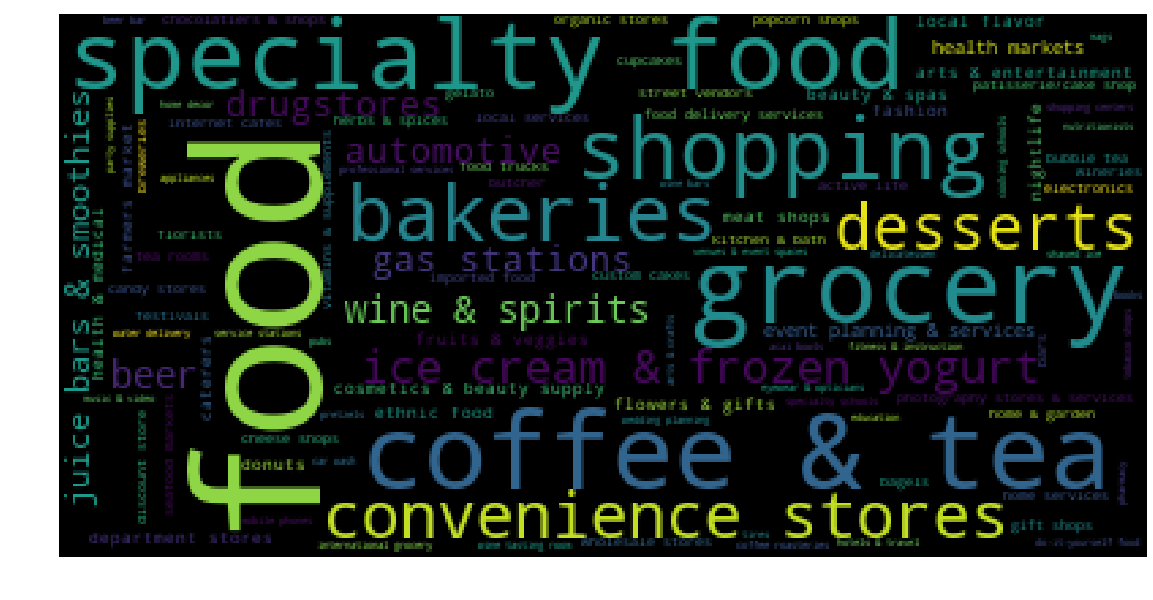

In [53]:


frequency_other_restaurants = nltk.FreqDist(other_restaurants_categories)
wordcloud = WordCloud().generate_from_frequencies(frequency_other_restaurants)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Categories in Scope for Restaurants
Based on our above exploration, we noticed that many establishments have multiple categories. <br>
The establishments with the following categories seem to best match the restaurants I would like to analyze
(1) Restaurants, (2) Bakeries, (3) Juice Bars <br>
Hence, we will gather reviews for all the establishments that are in at least one of above categories. 
All other reviews will be outside the scope of our project.<br>

<b>Prototype </b>
For the prototype, we will look for all restaurants within top 50000 business establishments.

In [3]:
restaurant_id_set = set()
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 50000:
            break
        else:
            business_record = json.loads(business_json)
            
            #Check whether the business is a restaurant
            if business_record[u'categories'] is not None:
                if u'restaurants' in business_record[u'categories'].lower() \
                or u'bakeries' in business_record[u'categories'].lower() \
                or u'juice bars' in business_record[u'categories'].lower():
                    #print(business_record[u'categories'])
                    restaurant_id_set.add(business_record[u'business_id'])
                else:                    
                    continue            
                

In [4]:
print(len(restaurant_id_set))
restaurant_id_set = frozenset(restaurant_id_set)

15989


We will consider reviews of these 16000 establishments in restaurant category. <br>
The restaurant_id_set was converted to a frozenset so that it can't be accidentally modified. <br>

<b>Classification</b>
Collecting the files for classification <br>
(1) Look through firdt 200,000 reviews and collect positive and negative reviews.

In [5]:
## Collect reviews for the restaurants in the set
## Data Preparation
if True:
    review_count=0
    
    # Write the reviews in text format. 
    with open(intermediate_data_path+"yelp_restaurants_reviews_classification.txt", 'w' ,encoding='utf_8') as review_txt_file:
        with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
            for line_no, review_json in enumerate(review_json_file):
                if line_no > 200000:
                    break
                else:
                    review_record=json.loads(review_json)

                    #Check if the review is about a restaurant
                    if review_record[u'business_id'] not in restaurant_id_set or int(review_record[u'stars'])==3 :
                        continue
                    #Write restaurant review as a line in the new file
                    #escape new line characters in the original review file
                    if int(review_record[u'stars']) in [4,5]:
                        review='P'
                    else:
                        review='N'
                    
                    review_txt_file.write(str(int(review_record[u'stars'])) + '#$#' + review + '#$#' + review_record[u'text'].replace('\n', '\\n')+'\n')
                    review_count+=1
    print("Total number of reviews: ", review_count) 

Total number of reviews:  112662


# Classifier

# Preparing the Training and Test Dataset

In [5]:
training_reviews=pd.DataFrame()
ratings=[]
reviews_text=[]
with open( os.path.join(intermediate_data_path,"yelp_restaurants_reviews_classification_rev.txt") ,"r", encoding='utf_8') as fin:
    for line_no, line in enumerate(fin):
        if line_no >= 10000:
            break
        else:
            #print(line_no)
            text = line.strip().split('#$#')
            if text[1]=='P':
                rating_val=1
            else:
                rating_val=0
            ratings.append(rating_val)    
            reviews_text.append(text[2].replace('\\n', '\n'))
training_reviews['rating']= ratings
training_reviews['text']= reviews_text
print("Total Number of Reviews in Training:",training_reviews.shape)

Total Number of Reviews in Training: (10000, 2)


In [6]:
# Restaurant Reviews Test Dataset 

test_reviews=pd.DataFrame()
ratings=[]
reviews_text=[]
with open( os.path.join(intermediate_data_path,"yelp_restaurants_reviews_classification_rev.txt") ,"r", encoding='utf_8') as fin:
    for line_no, line in enumerate(fin):
        if line_no >= 13001:
            break
        elif line_no <=10000:
            pass
        elif 10001 <= line_no <= 13000:
            #print(line_no)
            text = line.strip().split('#$#')
            if text[1]=='P':
                rating_val=1
            else:
                rating_val=0
            ratings.append(rating_val)    
            reviews_text.append(text[2].replace('\\n', '\n'))
            
test_reviews['rating']= ratings
test_reviews['text']= reviews_text
print("Total Number of Reviews in Test Dataset:",test_reviews.shape)

Total Number of Reviews in Test Dataset: (3000, 2)


Preview the dataframe. Rating = 1 means the review is positive and Rating = 0 means the review is negative. 

In [11]:
training_reviews.head(5)

,rating,text
0,1,"Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.\n\nDrink prices were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!"
1,1,"I'll be the first to admit that I was not excited about going to La Tavolta. Being a food snob, when a group of friends suggested we go for dinner I looked online at the menu and to me there was nothing special and it seemed overpriced. Im also not big on ordering pasta when I go out. Alas, I was outnumbered. Thank goodness! I ordered the sea bass special. It was to die for. Cooked perfectly, seasoned perfectly, perfect portion. I can not say enough good things about this dish. When the ser..."
2,0,"This place has gone down hill. Clearly they have cut back on staff and food quality\n\nMany of the reviews were written before the menu changed. I've been going for years and the food quality has gone down hill.\n\nThe service is slow & my salad, which was $15, was as bad as it gets.\n\nIt's just not worth spending the money on this place when there are so many other options."
3,1,"Like walking back in time, every Saturday morning my sister and I was in a bowling league and after we were done, we'd spend a few quarters playing the pin ball machines until our mother came to pick us up.\n\nMy sister was daring and play the machines hard, she was afraid of that ""tilt"" showing up and freezing the game. I, on the other hand was a bit more gentler and wanted to make sure I got my quarter's worth.\n\nThis place has rows and rows of machines, some are really old and some are ..."
4,0,"Walked in around 4 on a Friday afternoon, we sat at a table just off the bar and walked out after 5 min or so. Don't even think they realized we walked in. However everyone at the bar noticed we walked in!!! Service was non existent at best. Not a good way for a new business to start out. Oh well, the location they are at has been about 5 different things over the past several years, so they will just be added to the list. SMDH!!!"


1    0.7649
0    0.2351
Name: rating, dtype: float64

Predicting only 1 = 76.49% accuracy


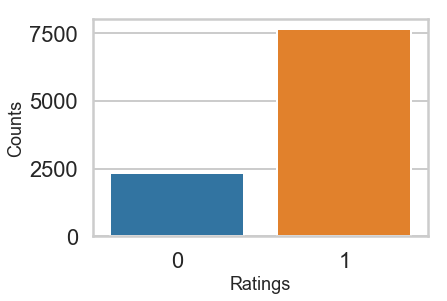

In [9]:
# Check the frequency of class variable
print(training_reviews.rating.value_counts(normalize=True))
counts = training_reviews.rating.value_counts()
print("\nPredicting only 1 = {:.2f}% accuracy".format(counts[1] / sum(counts) * 100))

ax = sns.countplot(x="rating", data=training_reviews)
plt.xlabel('Ratings',fontsize=18)
plt.ylabel('Counts',fontsize=18)
#plt.legend()
plt.show(ax)

<b>Analysis </b>
As we are dealing with imbalanced class (76% Positive rating), We will use SMOTE upsampling while building the classifier. <br>

In [19]:
X = training_reviews.text
y = training_reviews.rating

In [20]:
def score_cross_validation(alpha, min_df):

    ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    sm = SMOTE()

    accs = []
    #f1s = []
    #cms = []

    vectorizer = CountVectorizer(min_df = min_df)
    nb_classifier = MultinomialNB(alpha = alpha)

    for train_index, test_index in ss.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit vectorizer and transform X train, then transform X test
        X_train_vect = vectorizer.fit_transform(X_train)
        X_test_vect = vectorizer.transform(X_test)

        # Oversample
        X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

        # Fit Naive Bayes on the vectorized X with y train labels, 
        # then predict new y labels using X test
        nb_classifier.fit(X_train_res, y_train_res)
        y_pred = nb_classifier.predict(X_test_vect)

        # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
        accs.append(accuracy_score(y_test, y_pred))
        #f1s.append(f1_score(y_test, y_pred))
        #cms.append(confusion_matrix(y_test, y_pred))
    return sum(accs) / len(accs) * 100.0
    #print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
    #print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
    #print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

In [22]:
# Find the best parameters through hyperparameter tuning

# Initialize the best parameters
best_alpha = None
best_min_df= None
maxscore=-np.inf

alphas = [0.01, .1, 1, 5, 10, 50]
min_dfs=[1, 0.1, 0.01, 0.001, 0.0001]

#Find the best value for alpha and min_df, and the best classifier

for alpha in alphas:
    for min_df in min_dfs:
        score = score_cross_validation(alpha,min_df)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

alpha:  0.01  min_df:  1  score: 90.82000000000001
alpha:  0.01  min_df:  0.1  score: 83.395
alpha:  0.01  min_df:  0.01  score: 90.08999999999997
alpha:  0.01  min_df:  0.001  score: 91.64999999999998
alpha:  0.01  min_df:  0.0001  score: 90.83
alpha:  0.1  min_df:  1  score: 91.67500000000001
alpha:  0.1  min_df:  0.1  score: 83.34000000000002
alpha:  0.1  min_df:  0.01  score: 90.13499999999999
alpha:  0.1  min_df:  0.001  score: 91.855
alpha:  0.1  min_df:  0.0001  score: 91.53
alpha:  1  min_df:  1  score: 91.92
alpha:  1  min_df:  0.1  score: 83.39999999999999
alpha:  1  min_df:  0.01  score: 90.14000000000001
alpha:  1  min_df:  0.001  score: 91.84500000000003
alpha:  1  min_df:  0.0001  score: 91.98
alpha:  5  min_df:  1  score: 91.83
alpha:  5  min_df:  0.1  score: 83.31
alpha:  5  min_df:  0.01  score: 90.135
alpha:  5  min_df:  0.001  score: 91.88499999999999
alpha:  5  min_df:  0.0001  score: 91.845
alpha:  10  min_df:  1  score: 91.245
alpha:  10  min_df:  0.1  score: 83.1

In [28]:
# Build the base model using the best hyper-parameters

best_min_df = 0.001
best_alpha = 1

sm = SMOTE(random_state=42)


X_train_full = training_reviews.text
y_train_full = training_reviews.rating
X_test_full = test_reviews.text
y_test_full = test_reviews.rating

vectorizer = CountVectorizer(min_df = best_min_df)
nb_classifier = MultinomialNB(alpha = best_alpha)

# Fit vectorizer and transform X train, then transform X test
X_train_full_vect = vectorizer.fit_transform(X_train_full)
X_test_full_vect = vectorizer.transform(X_test_full)

# Oversample
X_train_full_res, y_train_full_res = sm.fit_sample(X_train_full_vect, y_train_full)

# Fit Naive Bayes on the vectorized X with y train labels, 
# then predict new y labels using X test
nb_classifier.fit(X_train_full_res, y_train_full_res)
y_pred_full = nb_classifier.predict(X_test_full_vect)

# Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
print("\nModel Accuracy: {:.2f}%".format(accuracy_score(y_test_full, y_pred_full) * 100))
print("\nF1 score : {:.2f}%".format(f1_score(y_test_full, y_pred_full) * 100))
print("\nConfusion Matrix: \n {}".format(confusion_matrix(y_test_full, y_pred_full)))


Model Accuracy: 90.77%

F1 score : 94.00%

Confusion Matrix: 
 [[ 552  173]
 [ 104 2171]]


# Strong Predictive Features
Next,  Lets look at a few strongly predictive features available in positive reviews and negative reviews respectively.

In [42]:
# Strong Predictive Features
words = np.array(vectorizer.get_feature_names())
x = np.eye(X_train_full_res.shape[1])
probs = nb_classifier.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

In [48]:
# Good Words and Bad Words with their probabilities
good_words = words[ind[:20]]
good_prob = probs[ind[:20]]

bad_words = words[ind[-20:]][::-1]
bad_prob = probs[ind[-20:]][::-1]

In [50]:
# List of top 20 words predicting Negative Reviews
print("Good words\t     P(Positive | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(Positive | word)
                 gem 0.98
              heaven 0.98
               donut 0.98
                feta 0.98
              delish 0.98
          phenomenal 0.97
          refreshing 0.97
                 art 0.97
          disappoint 0.97
            pleasure 0.97
          pleasantly 0.97
             nutella 0.96
                vous 0.96
              divine 0.96
               était 0.96
           fountains 0.96
                 lon 0.96
       knowledgeable 0.96
          watermelon 0.96
          affordable 0.96


In [51]:
# List of top 20 words predicting Negative (Not Positive) Reviews
print("Bad words\t     P(Positive | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Bad words	     P(Positive | word)
      unprofessional 0.02
            downhill 0.03
           tasteless 0.03
            horrible 0.04
              filthy 0.04
               worse 0.05
          unfriendly 0.05
              rudely 0.05
               awful 0.05
           miserable 0.05
               worst 0.05
          disgusting 0.05
              refund 0.05
        unacceptable 0.06
            terrible 0.07
           poisoning 0.07
         incompetent 0.07
               lousy 0.07
               stale 0.07
                rude 0.08


# Prediction Error

In [85]:
test_reviews['cv_nb_pred']=y_pred_full

In [98]:
print('------------------------------------------------------------')
print("Actually Positive Reviews, Predicted as Nagative Reviews")
print('------------------------------------------------------------')
print(test_reviews[(test_reviews.rating == 1) & (test_reviews.cv_nb_pred == 0)]['text'].head(2))

------------------------------------------------------------
Actually Positive Reviews, Predicted as Nagative Reviews
------------------------------------------------------------
66    Really good food, but beware the portions are huge!!!  Was full off of the truffle fries alone with brisket and French dip to follow, didn't even finish half of the later 2 and ended up having to throw away leftovers due to hotel not having a refrigerator...only complaint was the long wait almost an hour just to find out they hadn't put our name down on the list or failed to call us when we were waiting right outside the entrance, luckily they got us a table immediately upon discovering the ...
82    This review is based entirely on a stuffed Chicago-style pizza that we got to go.  \n\nIt was DELICIOUS.  I can honestly say I can't wait to order it again.\n\nWhen we called, we were given a time an hour and a half later to come pick it up.  This is not the place to go if you are in a hurry.  I'm pretty int

In [99]:
print('------------------------------------------------------------')
print("Actually Nagative Reviews, Predicted as Positive Reviews")
print('------------------------------------------------------------')
print(test_reviews[(test_reviews.rating == 0) & (test_reviews.cv_nb_pred == 1)]['text'].head(2))

------------------------------------------------------------
Actually Nagative Reviews, Predicted as Positive Reviews
------------------------------------------------------------
10    I have my own Nonna so when I found out that this place was run by old-school Italians I was overjoyed.  My experience with them, after many visits, is that despite their kind demeanour the food is nothing like home cooking.  The sauce is so heavy on the oregano and tinned tomato concentrate and it tastes as if they add sugar to reduce the acidity - very mangiacake. Because the sauce is so poor, their sandwiches taste like the ones you get Pizza Pizza.  Their chicken parmigianna is cafeteria...
51                                                                                                                                                                                                                                                                                                                         

In [97]:
# # ROC Curve
# import scikitplot as skplt
# import matplotlib.pyplot as plt

# skplt.metrics.plot_roc(y_test_full, nb_classifier.predict_proba(X_test_full_vect), classes_to_plot =0, plot_micro=False, plot_macro=False)
# plt.show()

# TF-IDF Vectorizer
Then, We try a TD-IDF vectorizer

In [75]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
## Lemmatize Data
def lemmatize_set(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    # p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        lemmatized_tokens = [wordnet_lemmatizer.lemmatize(i, pos="v") for i in stopped_tokens]
        # add tokens to list
        texts.append(' '.join(lemmatized_tokens))
    return texts

In [67]:
training_reviews['lemmatized_text']=lemmatize_set(training_reviews.text)

In [79]:
test_reviews['lemmatized_text']=lemmatize_set(test_reviews.text)

## Demonstration of Reviews and corresponding Lemmatized Reviews

In [73]:
training_reviews.text[0]

"Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.\n\nDrink prices were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!"

In [74]:
training_reviews.lemmatized_text[0]

'go lunch steak sandwich delicious caesar salad absolutely delicious dress perfect amount dress distribute perfectly across leaf know go salad perfect drink price pretty good server dawn friendly accommodate happy summation great pub experience would go'

In [76]:
X = training_reviews.lemmatized_text
y = training_reviews.rating

In [77]:
def score_tfidf_cross_validation(alpha, min_df):

    ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)

    accs = []
    #f1s = []
    #cms = []

    tfidfvectorizer = TfidfVectorizer(min_df = min_df, stop_words='english')
    nb_classifier = MultinomialNB(alpha = alpha)

    for train_index, test_index in ss.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit vectorizer and transform X train, then transform X test
        X_train_vect = tfidfvectorizer.fit_transform(X_train)
        X_test_vect = tfidfvectorizer.transform(X_test)

        # Oversample
        X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

        # Fit Naive Bayes on the vectorized X with y train labels, 
        # then predict new y labels using X test
        nb_classifier.fit(X_train_res, y_train_res)
        y_pred = nb_classifier.predict(X_test_vect)

        # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
        accs.append(accuracy_score(y_test, y_pred))
        #f1s.append(f1_score(y_test, y_pred))
        #cms.append(confusion_matrix(y_test, y_pred))
    return sum(accs) / len(accs) * 100.0
    #print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
    #print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
    #print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

In [78]:
# Find the best parameters through hyperparameter tuning

# Initialize the best parameters
best_alpha = None
best_min_df= None
maxscore=-np.inf

alphas = [0.01, .1, 1, 5, 10, 50]
min_dfs=[1, 0.1, 0.01, 0.001, 0.0001]

#Find the best value for alpha and min_df, and the best classifier

for alpha in alphas:
    for min_df in min_dfs:
        score = score_tfidf_cross_validation(alpha,min_df)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

alpha:  0.01  min_df:  1  score: 89.47999999999998
alpha:  0.01  min_df:  0.1  score: 77.625
alpha:  0.01  min_df:  0.01  score: 89.075
alpha:  0.01  min_df:  0.001  score: 90.99000000000001
alpha:  0.01  min_df:  0.0001  score: 89.50999999999999
alpha:  0.1  min_df:  1  score: 90.64
alpha:  0.1  min_df:  0.1  score: 77.57
alpha:  0.1  min_df:  0.01  score: 89.07000000000001
alpha:  0.1  min_df:  0.001  score: 90.995
alpha:  0.1  min_df:  0.0001  score: 90.72000000000001
alpha:  1  min_df:  1  score: 90.78500000000001
alpha:  1  min_df:  0.1  score: 77.485
alpha:  1  min_df:  0.01  score: 89.03999999999999
alpha:  1  min_df:  0.001  score: 91.14999999999999
alpha:  1  min_df:  0.0001  score: 90.85000000000001
alpha:  5  min_df:  1  score: 88.78
alpha:  5  min_df:  0.1  score: 77.35499999999999
alpha:  5  min_df:  0.01  score: 88.96
alpha:  5  min_df:  0.001  score: 90.23999999999998
alpha:  5  min_df:  0.0001  score: 88.79999999999998
alpha:  10  min_df:  1  score: 87.66499999999999
al

In [80]:
# Build the base model using the best hyper-parameters

best_min_df = 0.001
best_alpha = 1

sm = SMOTE(random_state=42)


X_train_full = training_reviews.lemmatized_text
y_train_full = training_reviews.rating
X_test_full = test_reviews.lemmatized_text
y_test_full = test_reviews.rating

tfidfvectorizer = TfidfVectorizer(min_df = best_min_df, stop_words='english', ngram_range=(1, 3))
nb_classifier = MultinomialNB(alpha = best_alpha)

# Fit vectorizer and transform X train, then transform X test
X_train_full_vect = tfidfvectorizer.fit_transform(X_train_full)
X_test_full_vect = tfidfvectorizer.transform(X_test_full)

# Oversample
X_train_full_res, y_train_full_res = sm.fit_sample(X_train_full_vect, y_train_full)

# Fit Naive Bayes on the vectorized X with y train labels, 
# then predict new y labels using X test
nb_classifier.fit(X_train_full_res, y_train_full_res)
y_pred_full = nb_classifier.predict(X_test_full_vect)

# Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
print("\nModel Accuracy: {:.2f}%".format(accuracy_score(y_test_full, y_pred_full) * 100))
print("\nF1 score : {:.2f}%".format(f1_score(y_test_full, y_pred_full) * 100))
print("\nConfusion Matrix: \n {}".format(confusion_matrix(y_test_full, y_pred_full)))


Model Accuracy: 90.27%

F1 score : 93.44%

Confusion Matrix: 
 [[ 628   97]
 [ 195 2080]]


# Strong Predictive Features

In [81]:
# Strong Predictive Features
words = np.array(tfidfvectorizer.get_feature_names())
x = np.eye(X_train_full_res.shape[1])
probs = nb_classifier.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

In [82]:
# Good Words and Bad Words with their probabilities
good_words = words[ind[:20]]
good_prob = probs[ind[:20]]

bad_words = words[ind[-20:]][::-1]
bad_prob = probs[ind[-20:]][::-1]

In [83]:
# List of top 20 words predicting Negative Reviews
print("Good words\t     P(Positive | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(Positive | word)
    highly recommend 0.96
                 gem 0.95
              delish 0.94
          phenomenal 0.94
      friendly staff 0.93
    great food great 0.93
           delicious 0.92
           perfectly 0.92
            hit spot 0.92
             refresh 0.92
         great price 0.92
          amaze food 0.92
         staff super 0.92
           fantastic 0.91
              heaven 0.91
 great service great 0.91
          affordable 0.91
     fresh delicious 0.91
           wonderful 0.91
         place amaze 0.91


In [84]:
# List of top 20 words predicting Negative (Not Positive) Reviews
print("Bad words\t     P(Positive | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Bad words	     P(Positive | word)
            horrible 0.03
           tasteless 0.03
               awful 0.03
             disgust 0.04
               worst 0.04
         avoid place 0.04
               worse 0.04
    horrible service 0.05
       worst service 0.05
                poor 0.05
               roach 0.05
                rude 0.05
            terrible 0.05
    service horrible 0.06
         waste money 0.06
      unprofessional 0.06
          waste time 0.06
              ignore 0.06
       food mediocre 0.06
       service awful 0.07


In [ ]:
# Prediction Error

In [ ]:
test_reviews['tfidf_nb_pred']=y_pred_full

In [86]:
print('------------------------------------------------------------')
print("Actually Positive Reviews, Predicted as Nagative Reviews")
print('------------------------------------------------------------')
print(test_reviews[(test_reviews.rating == 1) & (test_reviews.cv_nb_pred == 0)]['text'].head(2))

------------------------------------------------------------
Actually Positive Reviews, Predicted as Nagative Reviews
------------------------------------------------------------
29                                                                                                                                                                                                     Dank as hell \n\nI'd smoke all the employees out with one huge joint the size of my head to show them how much I appreciate the food
34    This place had problems originally but they changed management and operation. The food here is better then the last and it LA quality food now you have to try it. Also the new management is very nice and if your a repeat customer they will give you free stuff like dumplings and egg roll. Huge improvement will go back again.
Name: text, dtype: object


In [87]:
print('------------------------------------------------------------')
print("Actually Nagative Reviews, Predicted as Positive Reviews")
print('------------------------------------------------------------')
print(test_reviews[(test_reviews.rating == 0) & (test_reviews.tfidf_nb_pred == 1)]['text'].head(2))

------------------------------------------------------------
Actually Nagative Reviews, Predicted as Positive Reviews
------------------------------------------------------------
24    I ordered the Red Velvet pancakes, but they were undercooked and tasted horrible after 3 bites I gave up. My Dad ordered the Chocolate french toast which was 1big slice of brioche bread which was very dry in the center. The only good thing we ordered was the Banana Split for 2. Service was great but then again the place was pretty empty in the afternoon. Booths are comfortable, bar stools look very uncomfortable and no way would I sit at the tables some of which are uneven. I would go back o...
26                                             I was excited to have dinner at the hotel since it's a little off the beaten path and there is a fantastic view out of the dining room. The hostess and server were both very curt. They got the job done, but we all suffered. They brought me a thimble full of wine. I or

## Classifier using TF-IDF and Logistics Regression

In [104]:
from sklearn.linear_model import LogisticRegression

In [101]:
def score_tfidf_cv_log_reg(c):

    ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)

    accs = []
    #f1s = []
    #cms = []

    tfidfvectorizer = TfidfVectorizer(min_df = min_df, stop_words='english')
    lr_classifier = LogisticRegression(penalty = 'l2', C = c, random_state=0)

    for train_index, test_index in ss.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit vectorizer and transform X train, then transform X test
        X_train_vect = tfidfvectorizer.fit_transform(X_train)
        X_test_vect = tfidfvectorizer.transform(X_test)

        # Oversample
        X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

        # Fit Naive Bayes on the vectorized X with y train labels, 
        # then predict new y labels using X test
        lr_classifier.fit(X_train_res, y_train_res)
        y_pred = lr_classifier.predict(X_test_vect)

        # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
        accs.append(accuracy_score(y_test, y_pred))
        #f1s.append(f1_score(y_test, y_pred))
        #cms.append(confusion_matrix(y_test, y_pred))
    return sum(accs) / len(accs) * 100.0
    #print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
    #print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
    #print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

In [102]:
# Find the best parameters through hyperparameter tuning

# Initialize the best parameters
best_c = None
maxscore=-np.inf

c_values = [0.001,0.01,0.1,1,10,100]

#Find the best value for alpha and min_df, and the best classifier

for c in c_values:
    score = score_tfidf_cv_log_reg(c)
    if score > maxscore:
        maxscore = score
        best_c = c
    print('c: ', c, ' score:', score)
print("Best score: {}".format(maxscore))
print("Best c: {}".format(c))

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


c:  0.001  score: 87.53
c:  0.01  score: 88.75500000000001
c:  0.1  score: 90.99000000000001
c:  1  score: 92.785
c:  10  score: 93.16000000000001
c:  100  score: 92.76499999999999
Best score: 93.16000000000001
Best c: 100


In [103]:
# Build the base model using the best hyper-parameters

best_c = 10

sm = SMOTE(random_state=42)


X_train_full = training_reviews.lemmatized_text
y_train_full = training_reviews.rating
X_test_full = test_reviews.lemmatized_text
y_test_full = test_reviews.rating

tfidfvectorizer = TfidfVectorizer(min_df = best_min_df, stop_words='english', ngram_range=(1, 3))
lr_classifier = LogisticRegression(penalty = 'l2', C = best_c, random_state=0)

# Fit vectorizer and transform X train, then transform X test
X_train_full_vect = tfidfvectorizer.fit_transform(X_train_full)
X_test_full_vect = tfidfvectorizer.transform(X_test_full)

# Oversample
X_train_full_res, y_train_full_res = sm.fit_sample(X_train_full_vect, y_train_full)

# Fit Naive Bayes on the vectorized X with y train labels, 
# then predict new y labels using X test
lr_classifier.fit(X_train_full_res, y_train_full_res)
y_pred_full = lr_classifier.predict(X_test_full_vect)

# Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
print("\nModel Accuracy: {:.2f}%".format(accuracy_score(y_test_full, y_pred_full) * 100))
print("\nF1 score : {:.2f}%".format(f1_score(y_test_full, y_pred_full) * 100))
print("\nConfusion Matrix: \n {}".format(confusion_matrix(y_test_full, y_pred_full)))


Model Accuracy: 92.23%

F1 score : 94.87%

Confusion Matrix: 
 [[ 613  112]
 [ 121 2154]]


## Classifier using TF-IDF and Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
def score_tfidf_cv_rf(m_depth, n_estimators):

    ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)

    accs = []
    #f1s = []
    #cms = []

    tfidfvectorizer = TfidfVectorizer(min_df = min_df, stop_words='english')
    rf_classifier = RandomForestClassifier(max_depth = m_depth, n_estimators= n_estimators, random_state=0)

    for train_index, test_index in ss.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit vectorizer and transform X train, then transform X test
        X_train_vect = tfidfvectorizer.fit_transform(X_train)
        X_test_vect = tfidfvectorizer.transform(X_test)

        # Oversample
        X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

        # Fit Naive Bayes on the vectorized X with y train labels, 
        # then predict new y labels using X test
        rf_classifier.fit(X_train_res, y_train_res)
        y_pred = rf_classifier.predict(X_test_vect)

        # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
        accs.append(accuracy_score(y_test, y_pred))
        #f1s.append(f1_score(y_test, y_pred))
        #cms.append(confusion_matrix(y_test, y_pred))
    return sum(accs) / len(accs) * 100.0
    #print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
    #print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
    #print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

In [119]:
# Find the best parameters through hyperparameter tuning

# Initialize the best parameters
best_md = None
best_n_estimator = None
maxscore=-np.inf

md_values = [8,10]
n_estimators = [10,20,50,80, 100]

#Find the best value for alpha and min_df, and the best classifier

for md in md_values:
    for n_estimator in n_estimators:
        score = score_tfidf_cv_rf(md,n_estimator)
        
        if score > maxscore:
            maxscore = score
            best_md = md
            best_n_estimator = n_estimator      
        print('md: ', md, 'n_estimator: ', n_estimator,' score:', score)
print("Best score: {}".format(maxscore))
print("Best md: {}".format(best_md))
print("Best n_estimator: {}".format(best_n_estimator))

md:  8 n_estimator:  10  score: 79.90499999999999
md:  8 n_estimator:  20  score: 81.79
md:  8 n_estimator:  50  score: 82.80999999999999
md:  8 n_estimator:  80  score: 83.095
md:  8 n_estimator:  100  score: 83.22
md:  10 n_estimator:  10  score: 80.94000000000001
md:  10 n_estimator:  20  score: 82.39500000000002
md:  10 n_estimator:  50  score: 83.355
md:  10 n_estimator:  80  score: 83.435
md:  10 n_estimator:  100  score: 83.72500000000001
Best score: 83.72500000000001
Best md: 10
Best n_estimator: 100


In [120]:
# Build the base model using the best hyper-parameters

best_md = 10
best_n_estimator = 100

sm = SMOTE(random_state=42)


X_train_full = training_reviews.lemmatized_text
y_train_full = training_reviews.rating
X_test_full = test_reviews.lemmatized_text
y_test_full = test_reviews.rating

tfidfvectorizer = TfidfVectorizer(min_df = best_min_df, stop_words='english', ngram_range=(1, 3))
rf_classifier = RandomForestClassifier(max_depth = best_md, n_estimators= best_n_estimator, random_state=0)

# Fit vectorizer and transform X train, then transform X test
X_train_full_vect = tfidfvectorizer.fit_transform(X_train_full)
X_test_full_vect = tfidfvectorizer.transform(X_test_full)

# Oversample
X_train_full_res, y_train_full_res = sm.fit_sample(X_train_full_vect, y_train_full)

# Fit Naive Bayes on the vectorized X with y train labels, 
# then predict new y labels using X test
rf_classifier.fit(X_train_full_res, y_train_full_res)
y_pred_full = rf_classifier.predict(X_test_full_vect)

# Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
print("\nModel Accuracy: {:.2f}%".format(accuracy_score(y_test_full, y_pred_full) * 100))
print("\nF1 score : {:.2f}%".format(f1_score(y_test_full, y_pred_full) * 100))
print("\nConfusion Matrix: \n {}".format(confusion_matrix(y_test_full, y_pred_full)))


Model Accuracy: 83.97%

F1 score : 89.76%

Confusion Matrix: 
 [[ 410  315]
 [ 166 2109]]


# Insights Generation from Reviews of one restaurant


## Topic Recognition
Topic Recognition using LDA

In this section, we will analyze reviews of few specific seafood restaurants to find topics from their reviews <br>

In [3]:
restaurant_id_set = set()
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 50000:
            break
        else:
            business_record = json.loads(business_json)
            
            #Check whether the business is a restaurant
            if business_record[u'categories'] is not None:
                if u'restaurants' in business_record[u'categories'].lower() \
                and u'seafood' in business_record[u'categories'].lower():
                    #print(business_record[u'categories'])
                    restaurant_id_set.add(business_record[u'business_id'])
                else:                    
                    continue  

In [5]:
gc.collect()

71

In [16]:
## Collect reviews for the restaurants in the set
## Data Preparation
if True:
    review_count=0
    
    # Write the reviews in text format. 
    with open(intermediate_data_path+"yelp_restaurants_reviews_topic_recognition.txt", 'w' ,encoding='utf_8') as review_txt_file:
        with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
            for line_no, review_json in enumerate(review_json_file):
                if line_no > 1500000:
                    break
                else:
                    review_record=json.loads(review_json)

                    #Check if the review is about a restaurant
                    if review_record[u'business_id'] not in restaurant_id_set:
                        continue
                    #Write restaurant review as a line in the new file
                    #escape new line characters in the original review file
                    if int(review_record[u'stars']) in [4,5]:
                        review='P'
                    else:
                        review='N'
                    
                    review_txt_file.write('#$#'.join((str(int(review_record[u'stars'])), review, review_record[u'review_id'], review_record[u'business_id'], review_record[u'user_id'], review_record[u'text'].replace('\n', '\\n')+'\n')))
                    
                    review_count+=1
    print("Total number of reviews: ", review_count) 

Total number of reviews:  74886


Now, lets try to find out find businesses with at least 1000 reviews
Total 74,886 reviews

In [121]:
reviews_source=pd.DataFrame()
ratings=[]
reviews_text=[]
business_ids=[]
user_ids=[]
with open( os.path.join(intermediate_data_path,"yelp_restaurants_reviews_topic_recognition_rev.txt") ,"r", encoding='utf_8') as fin:
    for line_no, line in enumerate(fin):
        #print(line_no)
        text = line.strip().split('#$#')
        ratings.append(text[1]) 
        business_ids.append(text[3])
        user_ids.append(text[4])
reviews_source['rating']= ratings
reviews_source['business_id']= business_ids
reviews_source['user_id']= user_ids

In [123]:
reviews_source['business_id'].value_counts()[:20]

yNPh5SO-7wr8HPpVCDPbXQ    2006
u4sTiCzVeIHZY8OlaL346Q    1657
rTS8LsUmNIiXsXydE49tPA    1525
S-oLPRdhlyL5HAknBKTUcQ    1139
T2tEMLpTeSMxLKpxwFdS3g    1129
YRyYbOSwvHkZsZOLv98oQg    1101
vx4YAA02Qz6khRD1fZ1MFA    1046
LYWbyu1EQM2o5hwHG5_Ldg     958
TkEMlu88OZn9TKZyeY9CJg     927
pik4ebdFa0UcUhnNkivFcg     889
6xgcHeLad-VaoTIQewK84A     857
Q7m8G4579-XYKV3LMW8V7g     847
rvnTFEq7R2ZHg0_CYbBNFw     841
p3YqOYELqXtLyHz9T49p_w     796
bjSC_jbrypke0l-bXXBmwQ     716
I-5qHCVwT7k_KH67-YOx3A     679
Ak08F6RqjHYmVCzweBbTrQ     667
ghDNHpqETRJGxG5iUtaZtw     634
STtrEGylaYOXoXQFLP5OAQ     630
XwJ6fZRVbxQYRsryy4-qDw     599
Name: business_id, dtype: int64

We will go ahead with topic recognition of business id: yNPh5SO-7wr8HPpVCDPbXQ
For Topic Recognition, we consider ratings 1,2 and 3 as negative review and 4 or 5 as positive review.

In [125]:
def grab_reviews(business_id):
    reviews_df=pd.DataFrame()
    ratings=[]
    reviews_text=[]
    with open( os.path.join(intermediate_data_path,"yelp_restaurants_reviews_topic_recognition_rev.txt") ,"r", encoding='utf_8') as fin:
        for line_no, line in enumerate(fin):
            text = line.strip().split('#$#')
            if text[3] == business_id:
                if text[1]=='P':
                    rating_val=1
                elif text[1]=='N':
                    rating_val=0
                ratings.append(rating_val)    
                reviews_text.append(text[5].replace('\\n', '\n'))
    reviews_df['rating']= ratings
    reviews_df['text']= reviews_text
    return reviews_df

In [126]:
bus_reviews=grab_reviews('yNPh5SO-7wr8HPpVCDPbXQ')

In [128]:
bus_reviews.head(5)

,rating,text
0,1,"First off food is DELICIOUS! By far my favorite restaurant in downtown Phoenix. I have tried so many different things from the menu and it never disappoints, but the Saturday night special Prime Rib and Horseradish Dauphinoise Potato is my favorite. Second, the service is amazing. Ian is my favorite waiter, will request him every time! He is so personable with a good sense of humor! He constantly is checking up to make sure everything is good (but not too much). He made the experience at the..."
1,1,"This is a tricky one. AB is a really cool looking spot, really nice decor and ambiance, comfy booths, it even smells like a new car.\n\nMy group was greeted promptly by smiling hosts, and seated in a nice booth. Drink orders were placed, and when our margaritas arrived, they were really, really off and tasted terrible. Even after stirring, and thinking positive thoughts- they just were off- not sweet enough, and didn't taste good. Our server was cool and he swapped them out for other stuff. ..."
2,1,We got the chicken club and the prime rib dip!!! French fries and side salad!! It was yummy!!!!!!:) Only problem was not a kids menu. They will make a few items for the kids!!! The chicken tenders... The kids did not like them... Not your normal kid friendly kid coating!!!
3,0,"I was not a fan of this location or the staff. The food was sub par, the service was lacking, and overall it was not a good experience. For the amount of $$ per dish I expect it to be prepared better"
4,0,"Our first stop in a wild bachelor party weekend around the Phoenix area. After doing some research for lunch I decided on the arrogant butcher. What a great name for a restaurant located in downtown Phoenix directly across from the Arizona Diamondbacks ball park. With a solid 4 stars and over 1200 reviews it had to be outstanding right? Unfortunately the arrogance overcame the actual experience that we received. Arriving during happy hour the restaurant was extremely dead, but spring break, ..."


1    0.848953
0    0.151047
Name: rating, dtype: float64


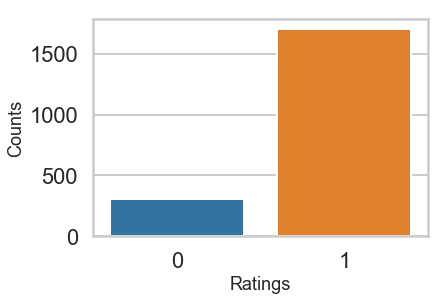

In [129]:
# Check the frequency of class variable
print(bus_reviews.rating.value_counts(normalize=True))

ax = sns.countplot(x="rating", data=bus_reviews)
plt.xlabel('Ratings',fontsize=18)
plt.ylabel('Counts',fontsize=18)
#plt.legend()
plt.show(ax)

It is an imbalanced problem.

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
no_features = 1000

In [133]:
bus_reviews['lemmatized_text']=lemmatize_set(bus_reviews.text)

## Topics Generation from Positive Reviews

In [143]:
# Positive Reviews
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(bus_reviews.lemmatized_text[bus_reviews.rating==1])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(bus_reviews.lemmatized_text[bus_reviews.rating==1])
tf_feature_names = tf_vectorizer.get_feature_names()

In [144]:
no_topics = 2

no_top_documents = 2
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [147]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_top_words = 4
print ('**********************')
print ('NMF Model Topics')
print ('**********************')
display_topics(nmf_model, tfidf_feature_names, no_top_words)
print ('\n')
print ('**********************')
print ('LDA Model Topics')
print ('**********************')
display_topics(lda_model, tf_feature_names, no_top_words)

**********************
NMF Model Topics
**********************
Topic 0:
good order come really
Topic 1:
great food service place


**********************
LDA Model Topics
**********************
Topic 0:
great cocktail orange make
Topic 1:
great good food place


In [148]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [149]:
display_topics(nmf_H, nmf_W, tfidf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
good order come really
I'm not sure why people find this place appealing. Our table had 7 different entrees and the butchers plate. The entrees came well before the appetizer and the only one of them that was decently good was the hamburger. Way overpriced with mediocre service and unimpressive steaks and seafood. I would not eat here again, even if the prices were slashed in half
We have heard a lot about this place and were finally able to go.. Service was friendly and fast and food was good. We got the jambolaya and the fish and chips which were both really good. The best part of our meal was the dessert.. We got the salted carmel pudding and it was sooo good! We would go back just for that dessert! Everything tasted nice and fresh it was excellent.
Topic 1:
great food service place
This was great...my husband had the double cheese burger and I had the jambalaya very good....the house made bun, was the perfect touch for the perfectly cooked med rate burger. The jambalaya wa

In [150]:
display_topics(lda_H, lda_W, tf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
great cocktail orange make
I'll be honest, Phoenix is the first city I've been to where yelp steered me wrong on almost all occasions. Arrogant Butcher fits that. We arrived on a Friday night, it was busy, understandably, so instead of waiting 45 minutes we sat at the bar.

Luckily there were menus at the seats because the bartender couldn't be bothered. He was obviously out of his element. We waited a good 8-10 minutes before he even "greeted" us. The greeting was, what do you want. Literally. That is what he said. This dude had no business being behind the bar, he was a dick, flat out. Other customers got the same treatment. Maybe he was a fill in for someone who called out, but there should have been 2 bartenders doing service drinks and taking care of the bar guests. I asked for an IPA his response "which one", aggressively, like I was an inconvenience to him and his poor bartending skills.

We ordered food, my colleague ordered a salad and I the burger. The burger was meh

## Topics Generation from Negative Reviews

In [151]:
# Positive Reviews
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(bus_reviews.lemmatized_text[bus_reviews.rating==0])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(bus_reviews.lemmatized_text[bus_reviews.rating==0])
tf_feature_names = tf_vectorizer.get_feature_names()

In [154]:
no_topics = 2
no_top_documents = 2

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [155]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_top_words = 4
print ('**********************')
print ('NMF Model Topics')
print ('**********************')
display_topics(nmf_model, tfidf_feature_names, no_top_words)
print ('\n')
print ('**********************')
print ('LDA Model Topics')
print ('**********************')
display_topics(lda_model, tf_feature_names, no_top_words)

**********************
NMF Model Topics
**********************
Topic 0:
food good place service
Topic 1:
wait minutes table seat


**********************
LDA Model Topics
**********************
Topic 0:
food good time service
Topic 1:
food good order place


In [156]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [157]:
display_topics(nmf_H, nmf_W, tfidf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
food good place service
We have been to almost all the fox restaurants here in Phoenix and have never been disappointed. This was the first time we were. Most of the food items were outstanding. My husband had the jambalaya our friends had the New York strip, and we shared the pretzel fondue and the mussels.  Plus for desert we all had the salted caramel pudding. All of these items were delicious. I had the carnitas and it was very mediocre. There was hardly any meat and it was in round balls, the corn cakes were slightly burnt, and the greens over powered the flavors. The service was alright he kept leaving too quickly and we ended up having to ask other waiters for things. This might be a one off situation so I would go back again and hopefully wont be disapointed.
The atmosphere is totally cool. If you're looking for an awesome place to eat in Phoenix, this is it. We were there over the holiday weekend and it seemed like everything was closed, but this place was hopping. Th

In [158]:
display_topics(lda_H, lda_W, tf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
food good time service
I really wanted to like this restaurant after seeing all the great pictures and reviews on Yelp. I was here on a Sunday night and the kitchen was slammed. They were sold out of the pasta dish I wanted and it took an hour (not exaggerating) for our plates to arrive. 

My friend told me you should never order seafood in the desert. Now I know why, because my salmon was so overcooked and dry that I had to ask for extra lemons just to make the taste bearable. My colleagues had burgers and a kale bowl and only 2/6 of us enjoyed our dinner.

Maybe it was an off night during our visit, but our experience was really disappointing. Although our server tried to be nice about the slow service, he did not really do anything to make up for it.
We came in this weekend and at at the bar
For 20min. No on
Even made eye contact with us. But I gave
Them the benefit, there were 4 of us so we were visible. We went upstairs to tilted kilt
Topic 1:
food good order place
If you

In [ ]:
# THE END